# 作業 : (Kaggle)鐵達尼生存預測
***
https://www.kaggle.com/c/titanic

# 作業1
* 試著使用鐵達尼號的例子，創立兩種以上的群聚編碼特徵( mean、median、mode、max、min、count 均可 )

In [65]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.simplefilter('ignore')
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

data_path = 'data/'
df0 = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df0['Survived']
df = df0.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [66]:
print(df.shape)
df.info()

(891, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 69.7+ KB


In [67]:
df['Embarked'] = df['Embarked'].fillna('Unknown')
for s in np.unique(df['Embarked'].astype(str)):
    print(f"Embarked={s}: {sum(df['Embarked'] == s)}")

Embarked=C: 168
Embarked=Q: 77
Embarked=S: 644
Embarked=Unknown: 2


In [68]:
df['Age'] = df['Age'].fillna(value=df['Age'].median())
df['Cabin'] = df['Cabin'].fillna(value='Unknown')
df['Embarked'] = df['Embarked'].replace('Unknown', 'S')

In [69]:
df0.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

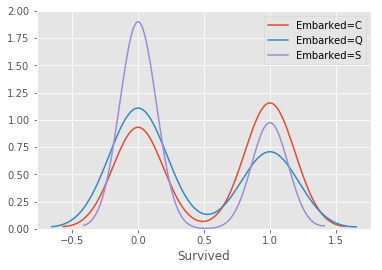

In [70]:
for e in np.unique(df['Embarked']):
    mask = df['Embarked'] == e
    sns.distplot(df0[mask]['Survived'], hist=False, label=f"Embarked={e}")
plt.legend()

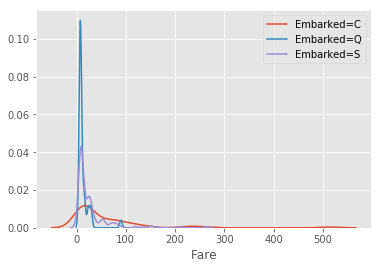

In [71]:
for e in np.unique(df['Embarked']):
    mask = df['Embarked'] == e
    sns.distplot(df0[mask]['Fare'], label=f"Embarked={e}", hist=False)
plt.legend()

In [72]:
# 取一個類別型欄位, 與一個數值型欄位, 做群聚編碼
"""
Your Code Here
"""
# 票價(Fare)對登船的口岸(Embarked)做群聚編碼
mean_df = df.groupby(['Embarked'])['Fare'].mean().reset_index()
mode_df = df.groupby(['Embarked'])['Fare'].apply(lambda x: x.mode()[0]).reset_index()
median_df = df.groupby(['Embarked'])['Fare'].median().reset_index()
max_df = df.groupby(['Embarked'])['Fare'].max().reset_index()
temp = pd.merge(mean_df, mode_df, how='left', on=['Embarked'])
temp = pd.merge(temp, median_df, how='left', on=['Embarked'])
temp = pd.merge(temp, max_df, how='left', on=['Embarked'])
temp.columns = ['Embarked', 'Fare_Mean', 'Fare_Mode', 'Fare_Median', 'Fare_Max']

df1 = pd.merge(df, temp, how='left', on=['Embarked'])
print(df.shape, df1.shape)
df1.head()

(891, 10) (891, 14)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_Mean,Fare_Mode,Fare_Median,Fare_Max
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,27.243651,8.0500,13.0,263.0000
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,59.954144,7.2292,29.7,512.3292
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,27.243651,8.0500,13.0,263.0000
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,27.243651,8.0500,13.0,263.0000
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,27.243651,8.0500,13.0,263.0000


In [73]:
# 原始特徵
# 只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(-1)
df.head()

5 Numeric Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']



,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


In [74]:
# 新特徵
# 只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df1.dtypes, df1.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
df1 = df1[num_features]
df1.head()

9 Numeric Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Fare_Mean', 'Fare_Mode', 'Fare_Median', 'Fare_Max']



,Pclass,Age,SibSp,Parch,Fare,Fare_Mean,Fare_Mode,Fare_Median,Fare_Max
0,3,22.0,1,0,7.2500,27.243651,8.0500,13.0,263.0000
1,1,38.0,1,0,71.2833,59.954144,7.2292,29.7,512.3292
2,3,26.0,0,0,7.9250,27.243651,8.0500,13.0,263.0000
3,1,35.0,1,0,53.1000,27.243651,8.0500,13.0,263.0000
4,3,35.0,0,0,8.0500,27.243651,8.0500,13.0,263.0000


# 作業2
* 將上述的新特徵，合併原有的欄位做生存率預估，結果是否有改善?

- Adding new features only improves the accuracy from 70.05% to 70.83%.

- The grouped feature combining "Embarked" and "Fare" is not effective.

In [75]:
# 原始特徵 + 邏輯斯迴歸
"""
Your Code Here
"""
MMEncoder = MinMaxScaler()
train_X = MMEncoder.fit_transform(df)
estimator = LogisticRegression(solver='lbfgs')
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.7004675175820018

In [76]:
# 新特徵 + 邏輯斯迴歸
"""
Your Code Here
"""
MMEncoder = MinMaxScaler()
train_X = MMEncoder.fit_transform(df1)
estimator = LogisticRegression(solver='lbfgs')
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.7083136421297069